# **Lab 4.1 Data Augmentation with PyTorch**

In [2]:
import torch
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.nn import functional as F
import random
import cv2
import numpy as np
from skimage.util import random_noise
import matplotlib.pyplot as plt
import os
from collections import Counter
from mpl_toolkits.axes_grid1 import ImageGrid

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return DataLoader() and print the information about the Dataset.

`transforms.Compose()` :
- `transforms.Resize()`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomAffine(degrees=45, translate=(0.1, 0.1),scale=(0.8, 1.2), shear=45)`
- `transforms.CenterCrop()`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>), [`ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html), [`Dataloader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#:~:text=Preparing%20your%20data%20for%20training%20with%20DataLoaders)

In [ ]:
def load_data(path):
    ### START CODE HERE ###
    transform = transforms.Compose([
        transforms.Resize((450, 450)),
        transforms.Pad(20),
        transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=20),
        transforms.CenterCrop(256),
        transforms.ToTensor()
    ])

    dataset = ImageFolder(root=path, transform=transform)

    class_map = dataset.class_to_idx #{'battleship': 0, 'patrol boat': 1, 'submarine': 2}
    targets = dataset.targets  #[0, 0, 1, 2, 1, ...]
    class_counts = Counter(targets)
    idx_to_class = {v: k for k, v in class_map.items()}

    data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)

    print("Train Dataset")
    for label in sorted(idx_to_class.keys()):
        class_name = idx_to_class[label]
        count = class_counts[label]
        print(f"\tNumber of images in class {class_name}: {count}")
    print(f"\tNumber of samples: {len(dataset)}")

    images, labels = next(iter(data_loader))

    fig = plt.figure(figsize=(20, 20))
    plt.style.use('dark_background')

    grid = ImageGrid(fig, 111,
                    nrows_ncols=(4, 4),  
                    axes_pad=0.5,  
                    )

    for ax, im, lb in zip(grid, images, labels):
        im_np = im.permute(1, 2, 0).numpy()
        ax.axis('off')
        ax.set_title(lb.item())
        ax.imshow(im_np)

    plt.show()

    return data_loader

    ### END CODE HERE ###

Use your load_data() function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class battleship: 44
	Number of images in class patrol boat: 35
	Number of images in class submarine: 35
	Number of samples: 114
```


![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/01.png?raw=true)

</details>

Train Dataset
	Number of images in class battleship: 44
	Number of images in class patrol boat: 35
	Number of images in class submarine: 35
	Number of samples: 114


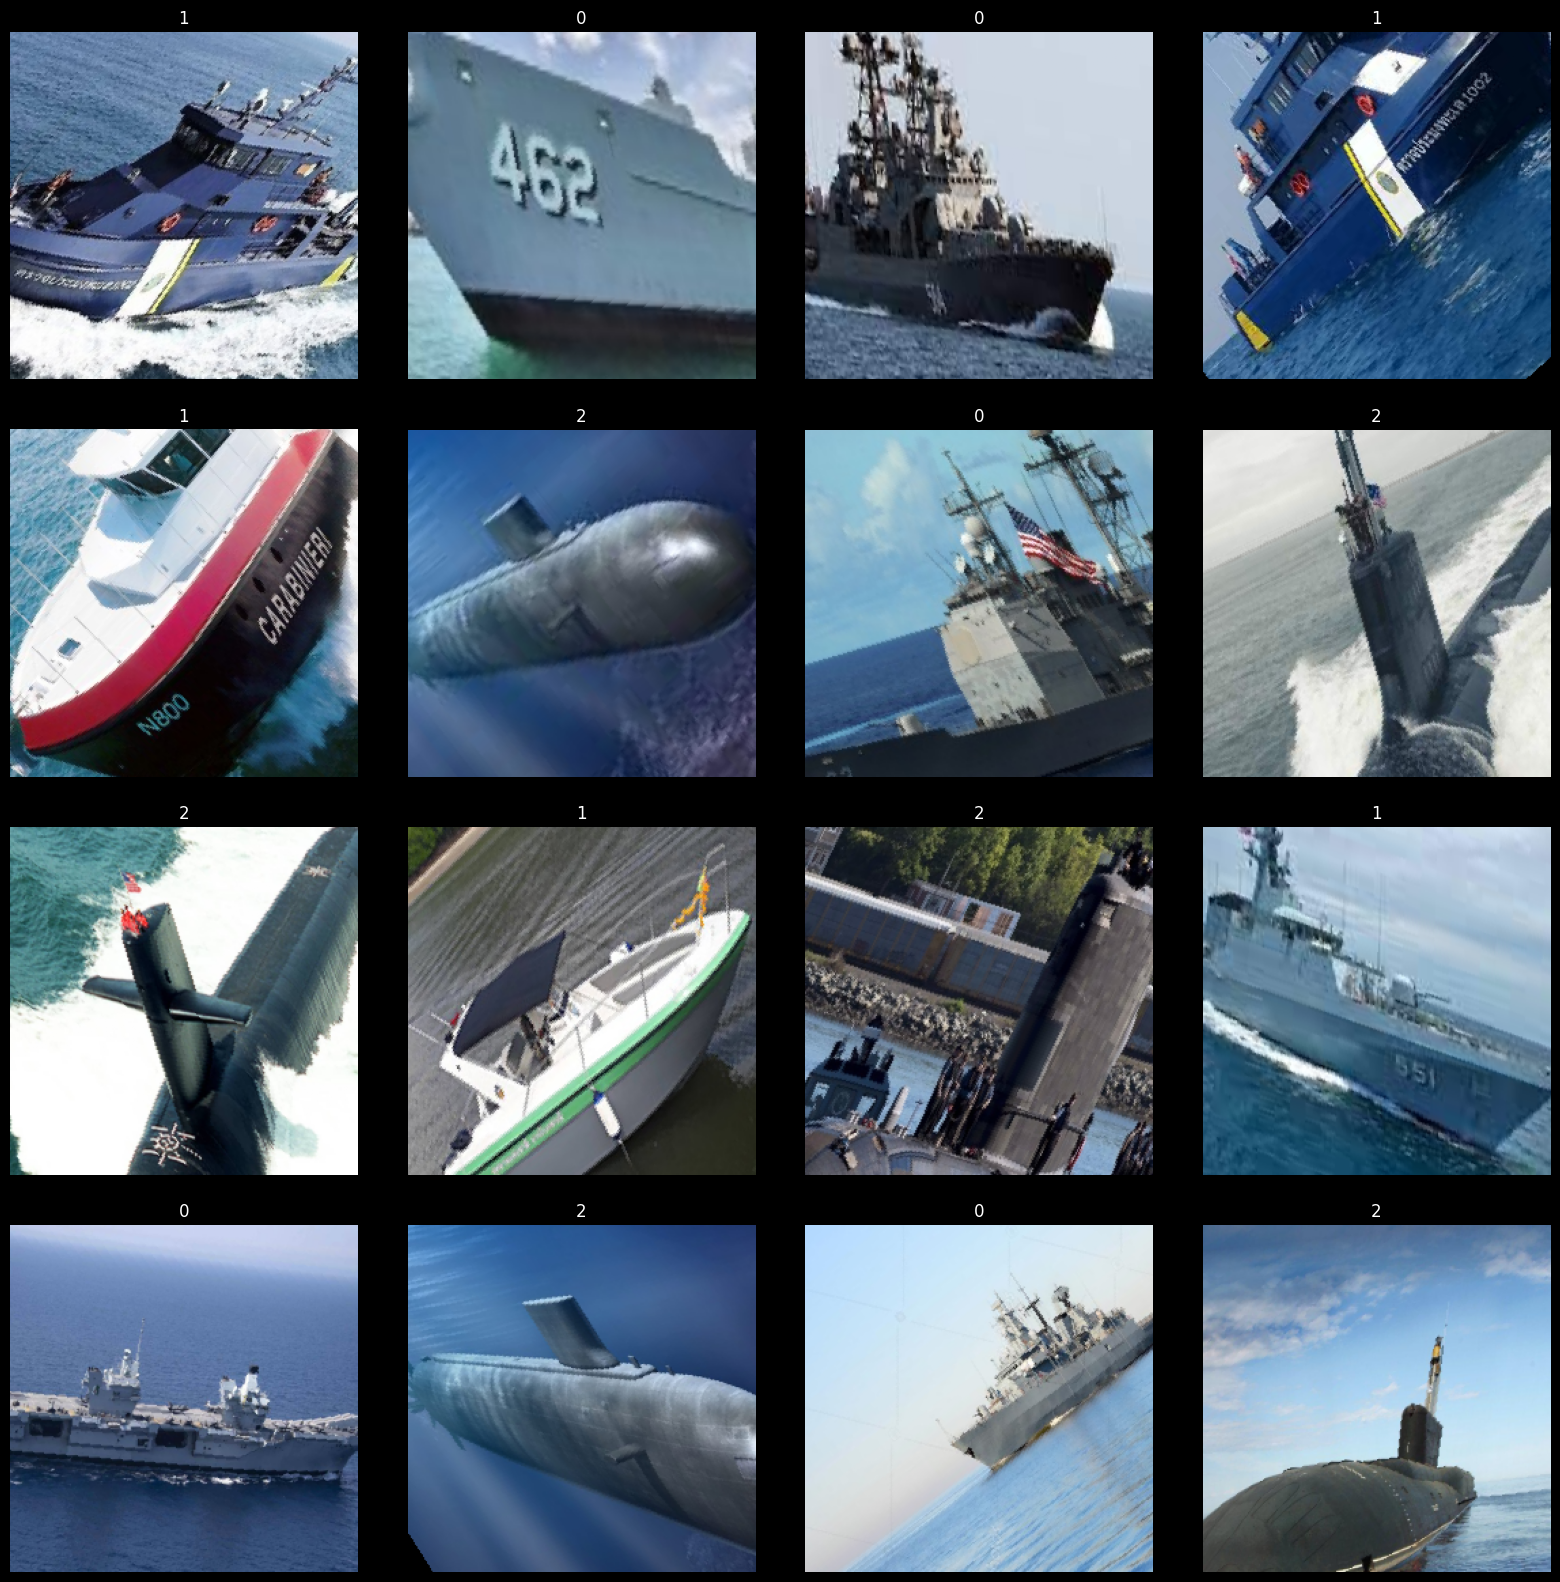

In [ ]:
### START CODE HERE ###
data_loader = load_data('Ship/Train')
### END CODE HERE ###

Now, let's create your own `CustomImageDataset` that performs the augmentation as in the previous section, but also includes the methods `add_gaussian_blur()` and `add_gaussian_noise()`. **<font color="red">DO NOT</font>** use `transforms.Compose()`.

Resource : [CustomImageDataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#:~:text=.show()-,Dataset%20class,-torch.utils.data)

In [11]:
class CustomImageDataset(Dataset):
    def __init__(self):
        pass

    
    def __getitem__(self, idx):
        image = None
        label = None
        return image,label
    

class Resize(object):
    """Rescale the image in a sample to a given size.
    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))  # ตรวจสอบว่า input ต้องเป็น int หรือ tuple เท่านั้น ไม่งั้นจะ error
        self.output_size = output_size

    def __call__(self, image): #ออบเจกต์ของคลาส สามารถเรียกใช้งานเหมือนฟังก์ชันได้
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        resized_img = cv2.resize(image, (new_h,new_w))

        print("before:",image.shape)
        print("after",resized_img.shape)

        return resized_img

class Pad(object):
    '''Pad ความกว้างและยาวของรูปออกตามตัวเเลขที่ใส่มาเช่น รูป 256x256 pad = 10 จะได้ 266x266 
    Pad ภาพสีเด้อ
    '''
    def __init__(self, len_pad):
        assert isinstance(len_pad, int)
        self.len_pad = len_pad
    
    def __call__(self, image):
        h, w = image.shape[:2]
        new_h = h + self.len_pad
        new_w = w + self.len_pad

        half = self.len_pad//2

        padded_img = np.zeros((new_h, new_w, 3), dtype=np.uint8)
        padded_img[half:new_h-half, half:new_w-half:, :] = image

        print("before:",image.shape)
        print("after",padded_img.shape)

        return padded_img
    
class CenterCrop(object):
    '''crop รูปภาพเป็นสี่เหลี่ยมจัตรัสขนาดตาม paramiter int
    '''
    def __init__(self, crop_size):
        assert isinstance(crop_size, int)
        self.crop_size = crop_size

    def __call__(self, image):

        #find center
        h,w = image.shape[:2]
        y,x = h//2, w//2
        half = self.crop_size//2

        croped_img = np.zeros((self.crop_size, self.crop_size, 3), dtype=np.uint8)
        croped_img[:,:,:] = image[y-half:y+half, x-half:x+half,:]

        print("before:",image.shape)
        print("after",croped_img.shape)

        return croped_img
    


(256, 256, 3)
(125, 125, 3)


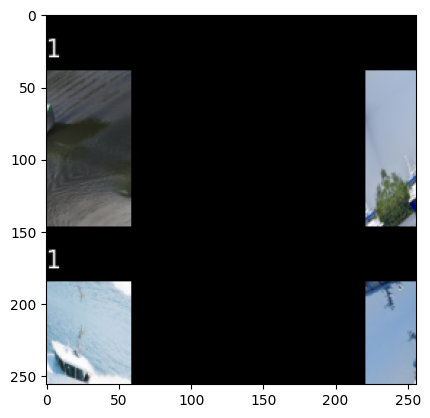

In [ ]:
#test Resize

image = cv2.imread('assets/01.png')

# png to jpg
if image.shape[2] == 4: 
    image = image[:, :, :3]

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cropped_image = image[140:396, 60:316]
image = cropped_image

resize = Resize((125,125))
new_img = resize(image)

plt.imshow(image)

before: (256, 256, 3)
after (276, 276, 3)


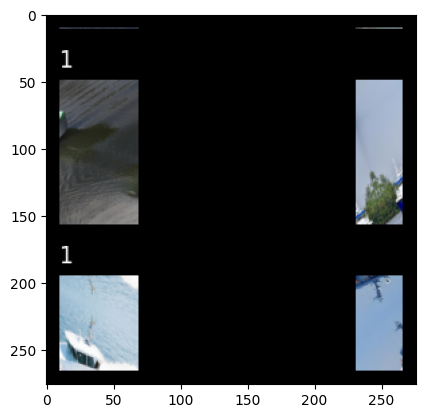

In [9]:
#test Pad

image = cv2.imread('assets/01.png')

# png to jpg
if image.shape[2] == 4: 
    image = image[:, :, :3]

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cropped_image = image[140:396, 60:316]
image = cropped_image

pad = Pad(20)
new_img = pad(image)

plt.imshow(new_img)

before: (612, 566, 3)
after (100, 100, 3)


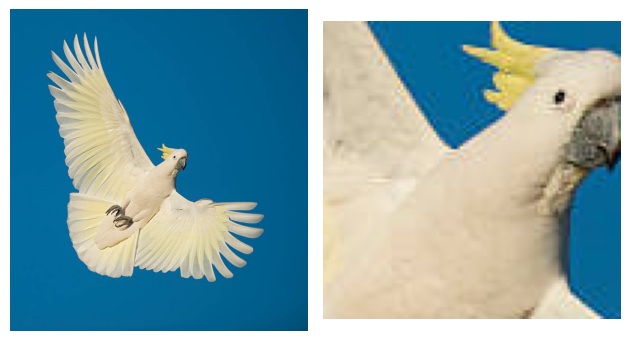

In [16]:
#test CenterCrop

image = cv2.imread('../Lab3_Image-Segmentation/asset/cockatoo.jpg')

# png to jpg
if image.shape[2] == 4: 
    image = image[:, :, :3]

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# cropped_image = image[140:396, 60:316]
# image = cropped_image

center_crop = CenterCrop(100)
new_img = center_crop(image)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[0].axis('off') 

axs[1].imshow(new_img)
axs[1].axis('off') 

plt.tight_layout()
plt.show()


Use your `CustomImageDataset()` function. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/02.png?raw=true)

</details>

In [ ]:
### START CODE HERE ###
dataset = CustomImageDataset(None)
dataloader = DataLoader(None)


### END CODE HERE ###

Questions
1. Discuss effects and benefits of fill_mode or padding_mode.
2. What would be amount of augmentation should be so that it would not effect the training performance?
3. How can we create Salt-and-Pepper Noise, which is the type that greatly affect the image quality?
4. What would be transform parameter to simulate camera lense effect?